In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [10]:
fs = 44100
length = 2048
max_peaks = 10 

In [11]:
# open json file
with open('dataset/dataset.json') as f:
    data = json.load(f)

In [12]:
X = data['magnitude_spectra']
y = data['labels']

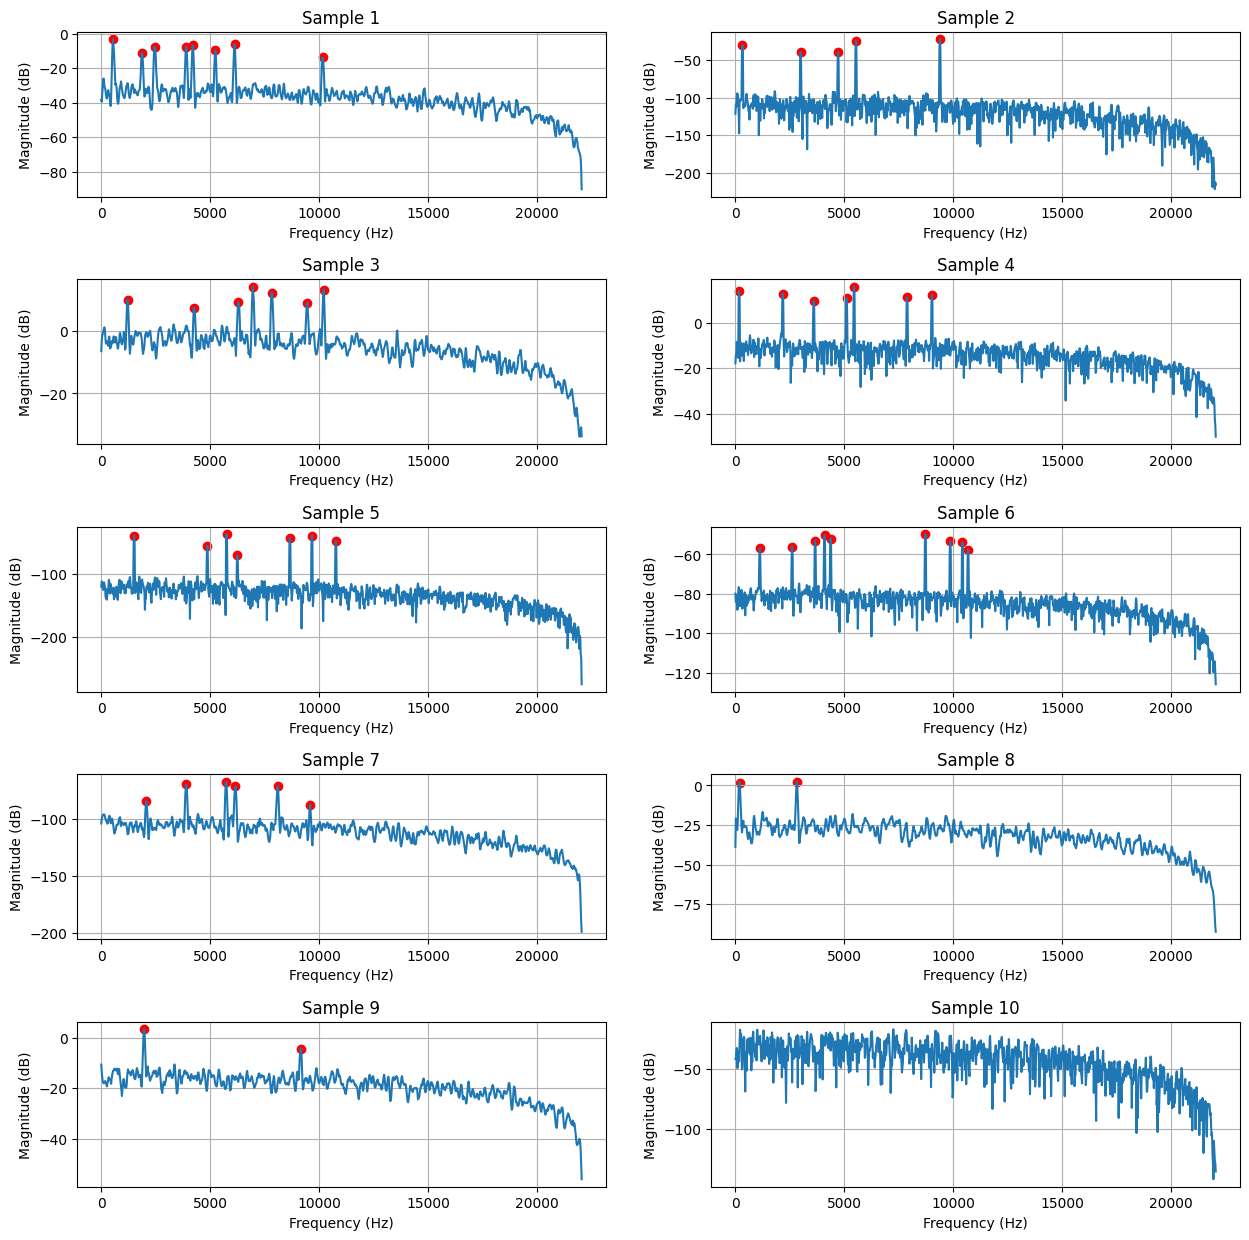

In [ ]:
plt.figure(figsize=(15, 15))

for i in range(10):
    magnitude_spectrum = np.array(X[i])

    peak_positions = np.array(y[i][1::2]) * length / 2
    peak_positions = peak_positions.astype(int)
    peak_positions = peak_positions[peak_positions != 0]

    plt.subplot(5, 2, i+1)
    plt.title('Sample ' + str(i+1))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')

    plt.scatter(peak_positions * fs / length, magnitude_spectrum[peak_positions], color='red')
    plt.plot(np.arange(len(magnitude_spectrum)) * fs / length, magnitude_spectrum)

    plt.subplots_adjust(hspace=0.5)
    plt.grid()

plt.show()

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = np.array(X_train)[:, :, np.newaxis]
X_val = np.array(X_val)[:, :, np.newaxis]
X_test = np.array(X_test)[:, :, np.newaxis]

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [54]:
X_train.shape[1], y_train.shape[1]

(1025, 20)

In [ ]:
model = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.LSTM(512, return_sequences=True),
    layers.Conv1D(256, 9, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(y_train.shape[1], activation='relu')
])

In [40]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 1025, 512)      │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 1017, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 508, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 506, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 64768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     8,290,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,630,996 (40.55 MB)

 Trainable params: 10,630,996 (40.55 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

Epoch 1/5


19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.1841 - loss: 65.9162 - val_accuracy: 0.0000e+00 - val_loss: 0.1727
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.7491 - loss: 0.1729 - val_accuracy: 0.8400 - val_loss: 0.1590
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.7890 - loss: 0.1649 - val_accuracy: 0.9850 - val_loss: 0.1609
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.9836 - loss: 0.1547 - val_accuracy: 0.9850 - val_loss: 0.1552
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.9807 - loss: 0.1566 - val_accuracy: 0.9850 - val_loss: 0.1559


In [45]:
# predict the labels of the test set
y_pred = model.predict(X_test, verbose=False)

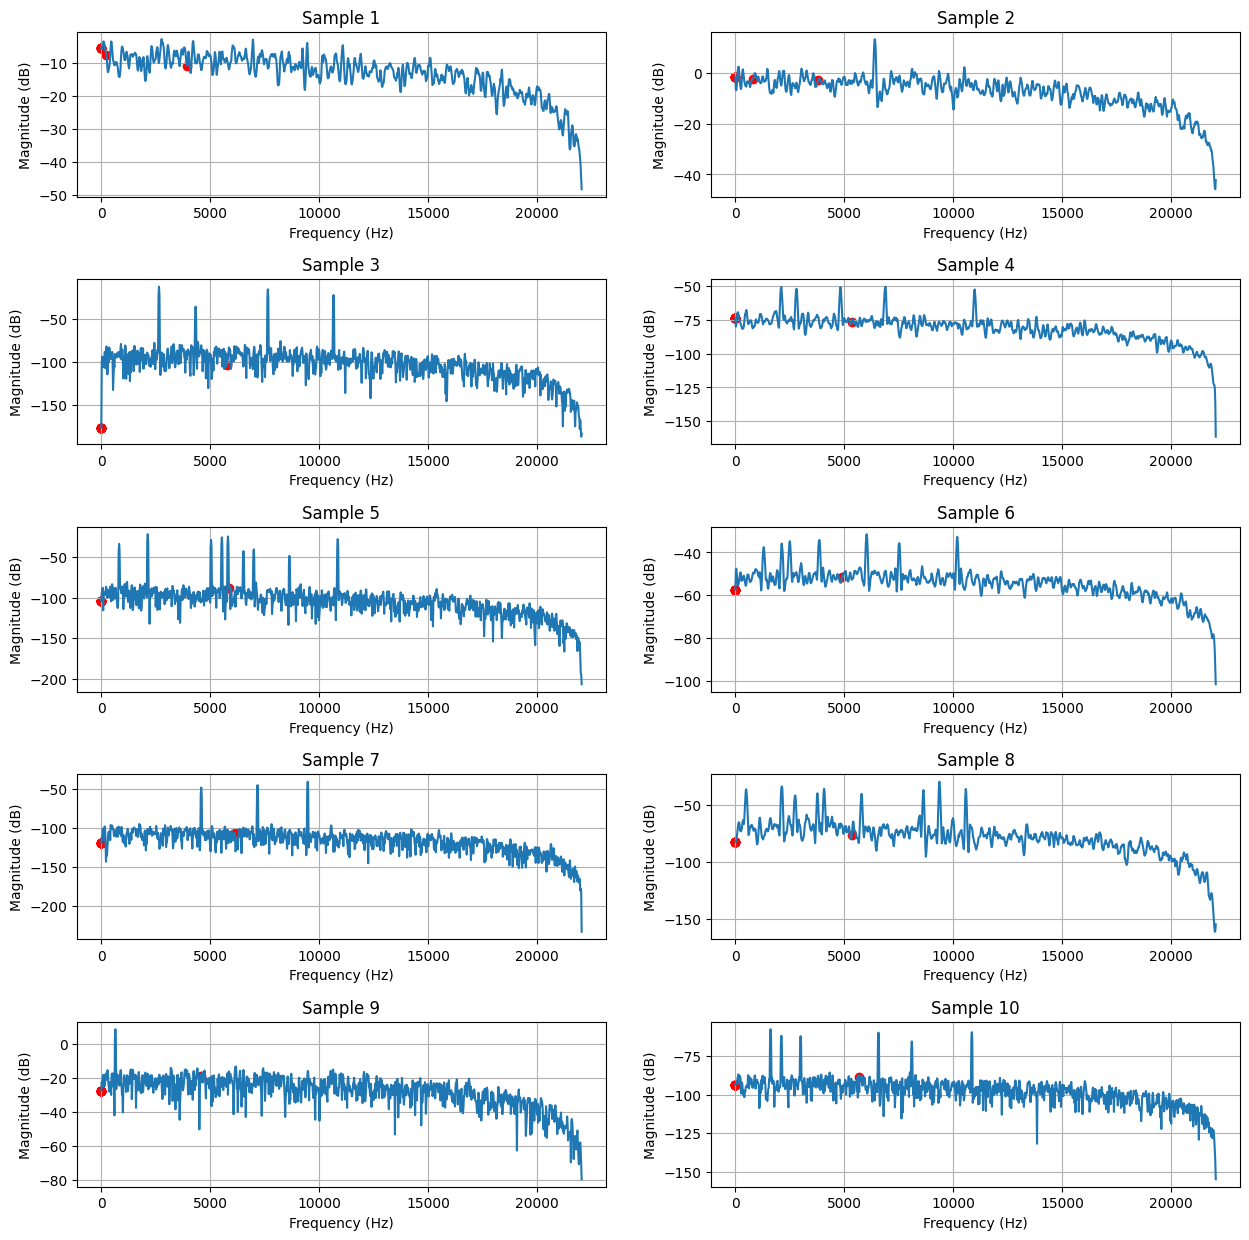

In [ ]:
plt.figure(figsize=(15, 15))

for i in range(10):
    magnitude_spectrum = np.array(X_test[i])

    peak_positions = np.array(y_pred[i][1::2]) * length / 2
    peak_positions = peak_positions.astype(int)

    plt.subplot(5, 2, i+1)
    plt.title('Sample ' + str(i+1))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')

    plt.scatter(peak_positions * fs / length, magnitude_spectrum[peak_positions], color='red')
    plt.plot(np.arange(len(magnitude_spectrum)) * fs / length, magnitude_spectrum)

    plt.subplots_adjust(hspace=0.5)
    plt.grid()

plt.show()